### Instructions
* Before training a modified model, change the `EXP_NUM` variable to a new number. This will be used to name the model and the results file and the older model & results will not be overwritten.
* ...

### Experiments
* DONE: Keep some data out of the training set to test the model on. To disk.
  * Don't use `train_test_split` for getting test data. Load it from disk.
* DONE: Get more data and test
* DONE: Try `ANNClassifier` -> Longer training time, overall less accurate
* TODO: Try BidiLSTM
* DONE: Try scaling - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* TODO: Change loss function / final activation - `SoftMax`

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

In [2]:
class LSTMClassifier(pl.LightningModule):
    # NOTE: All the bidirectional code can be removed. It is unnecessary for your case.
    def __init__(
        self,
        input_dim, # n_features = 2 here
        hidden_dim,
        output_dim,
        num_layers,
        dropout,
        bidirectional=True,
        learning_rate=1e-3,
        criterion=nn.BCEWithLogitsLoss()
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.dropout = dropout
        self.learning_rate = learning_rate
        self.criterion = criterion

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if self.bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.save_hyperparameters(ignore=['criterion'])

    def forward(self, x):
        # Zeroing out the hidden state and cell state for each batch of sequences (or each of the samples)
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(self.device)
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(self.device)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)

        out, (hidden, _) = self.lstm(x, (h0, c0))
        if self.bidirectional:
            out = self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            out = self.fc(hidden[-1,:,:])

        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)

        self.log('val_loss', loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)
        acc = ((torch.sigmoid(out) > 0.5).float() == y).float().mean()

        self.log('test_loss', loss)
        self.log('test_acc', acc)

        return {'test_loss': loss, 'test_acc': acc}

In [3]:
# Set seed for reproducibility
seed_everything(42)

# Load data from .npz file
dat = np.load("./unshuffled_mix_data.npz")
# NOTE: "unshuffled" in `unshuffled_mix_data` refers to the fact that the data is not shuffled across datasets. Within each dataset, the data is shuffled.
X, y = dat['X'], dat['y'] # Shuffled data

# test_dat = np.load("./standardscaled_test_data.npz")
# X_test, y_test = test_dat['X'], test_dat['y'] # Shuffled test data

# Use train_test_split to split the overall data into train + val sets # NOTE: test_size=0.1 -> 0.15 | Sometimes, a shape mismatch may happen if val.size is not large enough. Modify test_size accordingly. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True) # random_state=42) -> Not needed since seed_everything is used # 0.2 used earlier
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True) # random_state=42) -> Not needed since seed_everything is used # 0.2 used earlier
# Use train_test_split to split the training data into train + val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True) # random_state=42) # 0.2 used earlier

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
# (batch_size, seq_len, num_features) if batch_first=True

Global seed set to 42


((275, 20, 2), (31, 20, 2), (55, 20, 2), (275,), (31,), (55,))

In [4]:
'''
All parameters are aggregated in one place.
This is useful for reporting experiment params to experiment tracking software

'''

# NOTE: Old values that were tested, are in comments
p = dict(
    # Model parameters
    input_dim = 2, # Time-series with 2 feature channels
    hidden_dim = 100, # 10, # Less data, so smaller networks may generalize better | NOTE: 100 does lead to 1-order lower loss (0.001 -> 0.0001)
    output_dim = 1, # Avoids the need for a sigmoid, post Linear | Also, BCEWithLogitsLoss() performs Sigmoid internally
    num_layers = 2, # 1, # Number of LSTM layers | NOTE: More layers help up to a point, but also prolong training time
    # Training parameters
    batch_size = 16,
    max_epochs = 15, # 50, # Less data, so we may need more epochs. | NOTE: 50 leads to good results for num_layers=1
    dropout = 0.2, # 0.2, # Keep low for smaller networks & 0 for num_layers=1
    learning_rate = 0.001, # Keep low for slower networks
    criterion = nn.BCEWithLogitsLoss(), # Binary cross entropy loss (with logits)
    bidirectional = False, # False,
)

In [5]:
# Convert to torch tensors and data loaders
# NOTE: You technically don't need Dataset or DataLoader for only this much data
# Using them here for consistency with other notebooks & to make it easier to scale up (wrt batching etc.) 
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=p['batch_size'], pin_memory=True, num_workers=4)
val_loader = DataLoader(val_data, shuffle=False, batch_size=p['batch_size'], pin_memory=True, num_workers=4)
test_loader = DataLoader(test_data, shuffle=False, batch_size=p['batch_size'], pin_memory=True, num_workers=4)

In [6]:
# Set up logger
DIR_NAME = 'lstm_cf'
EXP_NUM = 23 # NOTE: Change version for each run to avoid overwriting checkpoints & logs
csv_logger = CSVLogger('./', name=f'{DIR_NAME}', version=f'{EXP_NUM}')

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    log_every_n_steps=1,
    enable_progress_bar=True,
    # fast_dev_run=True # For debugging
)

model = LSTMClassifier(
    input_dim=p['input_dim'],
    hidden_dim=p['hidden_dim'],
    output_dim=p['output_dim'],
    num_layers=p['num_layers'],
    dropout=p['dropout'],
    learning_rate=p['learning_rate'],
    criterion=p['criterion'],
    bidirectional=p['bidirectional'],
)

# NOTE: Check results.md for results
trainer.fit(model, train_loader, val_loader) # NOTE: Uncomment to train
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 122 K 
2 | fc        | Linear            | 101   
------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s, v_num=23]        

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 18/18 [00:06<00:00,  2.79it/s, v_num=23]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 119.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9818181991577148
        test_loss           0.03112286892031658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03112286892031658, 'test_acc': 0.9818181991577148}]

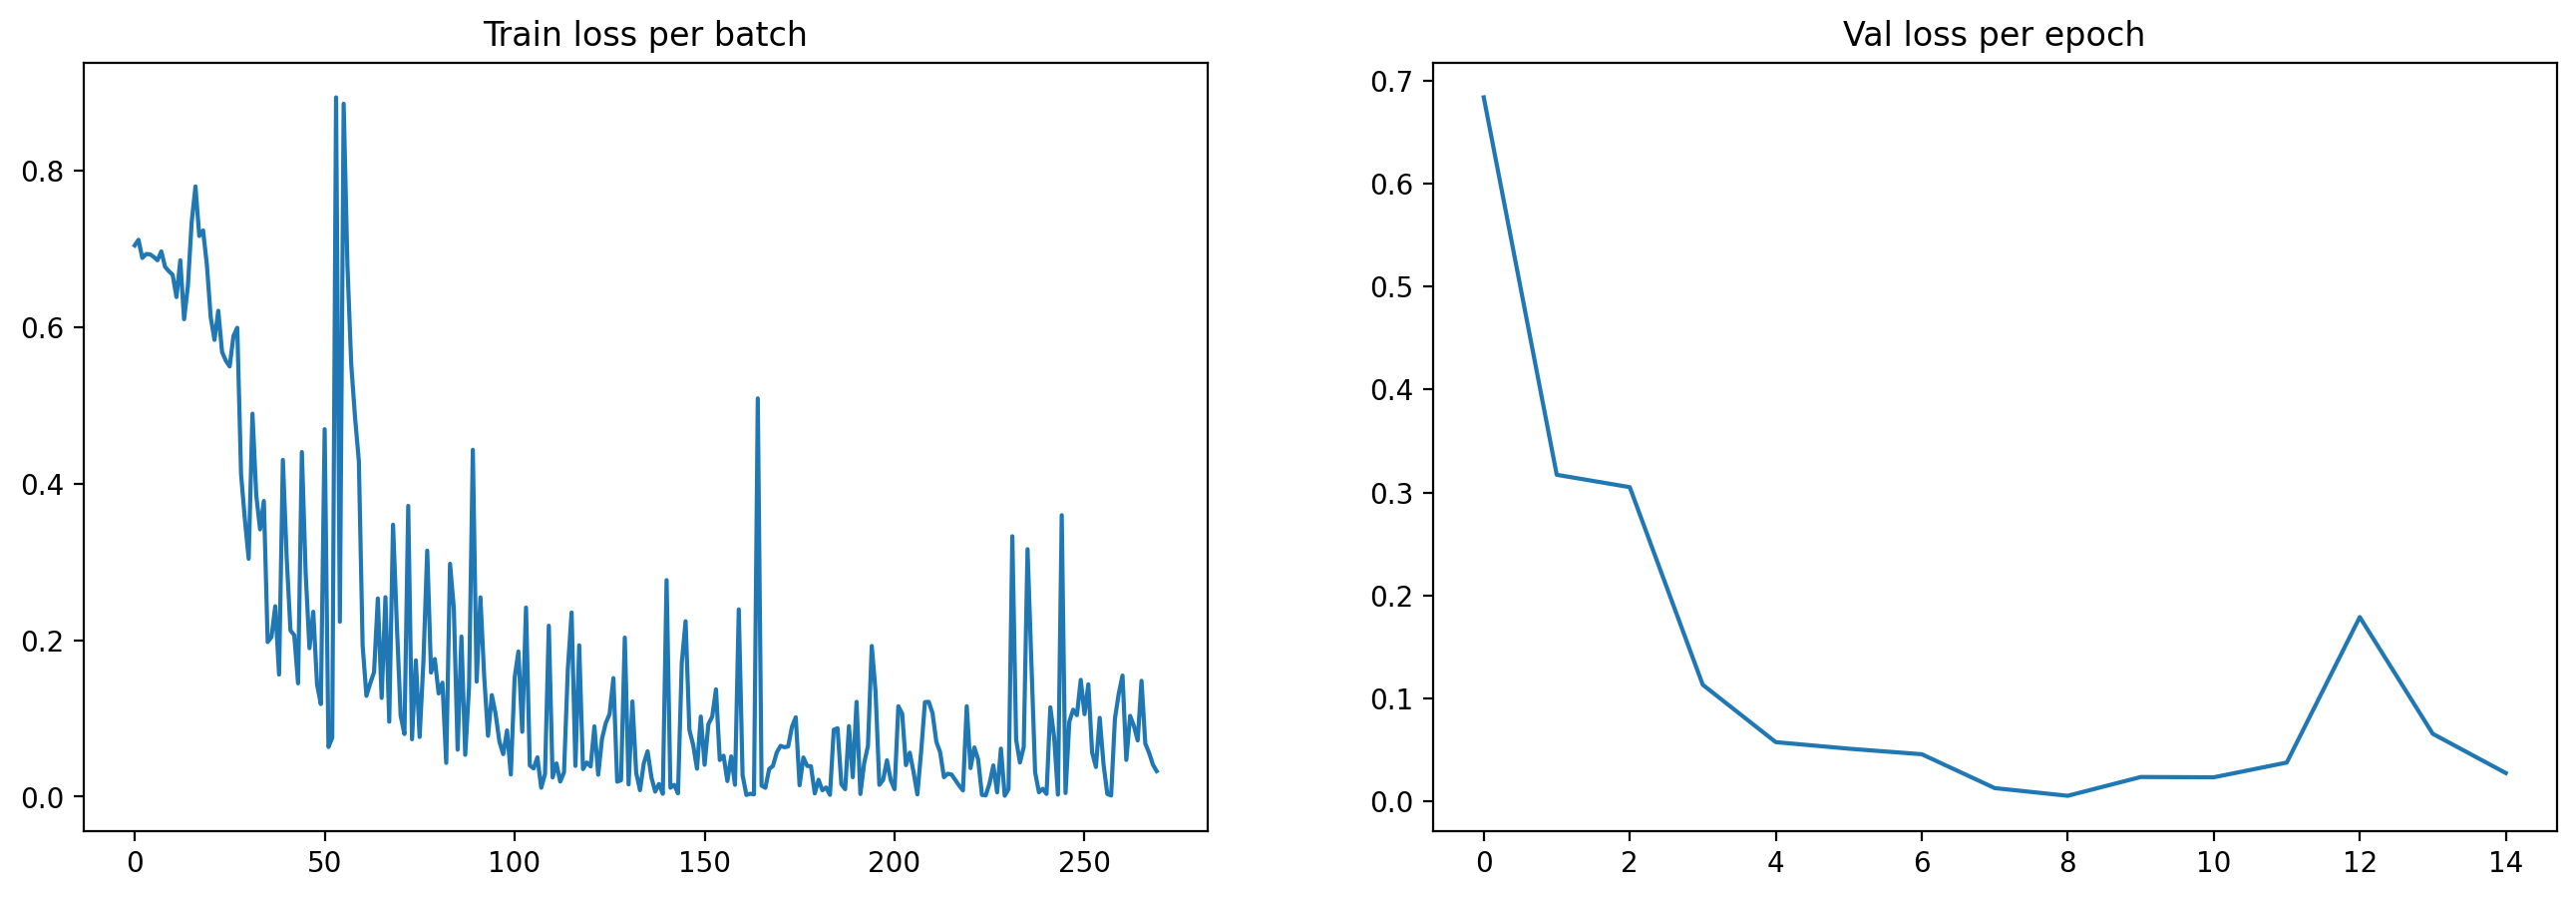

BCEWithLogits:
Train loss: 0.033
Val loss:   0.028
Test loss:  0.031


In [7]:
# Load & show metrics
metrics = pd.read_csv(f'./{DIR_NAME}/{EXP_NUM}/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Val loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'])
plt.savefig(f'./{DIR_NAME}/{EXP_NUM}/loss.png', dpi=200)
plt.show(block = True)

print('BCEWithLogits:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

In [8]:
def test_model(exp_num, chkpoint, sample, verbose=False):
    """
    Function to load a model per experiment & test on a sample

    Args:
        exp_num (int): Experiment number
        chkpoint (str): Checkpoint name. Check ./lstm_cf/{exp_num}/checkpoints/ for available checkpoints
        sample (tuple): Tuple of (X, y) to test on

    """
    # Load model
    model = LSTMClassifier.load_from_checkpoint(f'./lstm_cf/{exp_num}/checkpoints/{chkpoint}.ckpt', hparams_file=f'./lstm_cf/{exp_num}/hparams.yaml')
    if verbose:
        print(model)

    # Load data
    X, y = sample[0], np.array(sample[1])

    # Get prediction
    model.eval()
    with torch.no_grad():
        X_sample = torch.from_numpy(X).float().unsqueeze(0)
        y_sample = torch.from_numpy(y).float().unsqueeze(0)
        y_hat = model(X_sample)
        y_hat = torch.sigmoid(y_hat)
        y_hat = torch.round(y_hat)

    # Print results
    if verbose:
        print(f"Actual: {y_sample}")
        print(f"Pred:   {y_hat}")

    return y_sample.squeeze().numpy(), y_hat.squeeze().numpy()

In [9]:
# res = []
# for i in range(len(X_test)):
#     res.append(test_model(9, 'epoch=9-step=180', (X_test[i], y_test[i])))

# np.array(res)

# # calc accuracy
# acc = 0
# for i in range(len(res)):
#     if np.array_equal(res[i][0], res[i][1]):
#         acc += 1

# print(f'Accuracy: {acc / len(res)}')

## Results
* `res.append(test_model(4, 'epoch=9-step=160', (X_test[i], y_test[i])))` -> 0.52
* `res.append(test_model(5 or 6, 'epoch=9-step=180', (X_test[i], y_test[i])))` -> 0.84 (means `Trainer` and `test_step` are working properly)
* `res.append(test_model(7, 'epoch=49-step=900', (X_test[i], y_test[i])))` -> 0.8 | Overfitting on train data
* `res.append(test_model(8, 'epoch=9-step=360', (X_test[i], y_test[i])))` -> 0.84
* `res.append(test_model(9, 'epoch=19-step=...', (X_test[i], y_test[i])))` -> ...
* NOTE: Check results.md for more results. This matches `Trainer.test(...)` anyway.